In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import pyqosc as qo
import scipy as sp

In [2]:
def shortcut_impens(self, rho_0, tau, dy = None, timepoints = 101, err_tol_b = 1e-3, maxiter = 100, report = True,
                    plot_trajectory = False, save_to_osc = False):
    
    if not(timepoints & 1):
        timepoints += 1     # We make sure the number of timepoints is odd so that tau/2 is always a time point.
    midpoint = timepoints//2+1
    timelst = np.linspace(0, tau, timepoints)
    t_half = timelst[:midpoint]

    #####
    
    original_Omega_1 = self.Omega_1
    original_Omega_2 = self.Omega_2
    Ham, c_ops = self.dynamics()
    
    b = qt.destroy(self.N)
    bbx = b.dag()*b*(b+b.dag())/2
    bby = b.dag()*b*(b-b.dag())/(2*1j)
    
    b_0 = qt.expect(b, rho_0)

    rho_ss = qt.steadystate(Ham, c_ops)
    b_ss = qt.expect(b, rho_ss)
    bbx_ss = qt.expect(bbx, rho_ss) 
    bby_ss = qt.expect(bby, rho_ss)
    
    #####
    
    b_target = b_ss 
    iters = 0
    while True:
        iters += 1

        b_i = 0.5*(b_target+b_0) + 1j*dy
            
        db_firsthalf = 2/tau*(b_i-b_0)
        b_firsthalf = b_0 + db_firsthalf * t_half
        
        db_secondhalf = 2/tau*(b_target-b_i)
        b_secondhalf = b_i + db_secondhalf * t_half
        
        b_trajectory = np.concatenate((b_firsthalf, b_secondhalf[1:]))
        
        if iters == 1:
            b_og_trajectory = b_trajectory.copy()
        
        Omega = (1j*self.Delta + self.gamma_1/2 - self.gamma_2*np.abs(b_trajectory)) * b_trajectory
        Omega[:midpoint] -= db_firsthalf
        Omega[midpoint:] -= db_secondhalf
        
        self.Omega_1 = np.imag(Omega)
        self.Omega_2 = np.real(Omega)
        Ham, c_ops = self.dynamics()
        
        ###########
        rho_control = self.evolve(rho_0, timelst)
        rho_tau = rho_control[-1]
        b_tau = qt.expect(b, rho_tau)

        if plot_trajectory:
            b_control = qt.expect(b, rho_control)
            plt.title(f"iteration {iters}")
            plt.plot(np.real(b_og_trajectory), np.imag(b_og_trajectory), label = "original target trajectory")
            plt.plot(np.real(b_trajectory), np.imag(b_trajectory), label = "corrected target trajectory")
            plt.plot(np.real(b_control),np.imag(b_control), label = "resulting control trajectory")
            plt.legend(loc = "best")
            plt.show()
        ###########
        
        Delta_b = np.abs(b_tau-b_ss)
        
        if (iters == maxiter) or (Delta_b < err_tol_b):
            bbx_tau = qt.expect(bbx, rho_tau)
            bby_tau = qt.expect(bby, rho_tau)
            Delta_bbb = np.sqrt((bbx_tau-bbx_ss)**2+(bby_tau-bby_ss)**2)
            break
        else:
            offset_b = b_tau - b_ss
            b_target -= offset_b
    
    Omega_1_out = self.Omega_1.copy()
    Omega_2_out = self.Omega_2.copy()
    if not(save_to_osc):
        self.Omega_1 = original_Omega_1
        self.Omega_2 = original_Omega_2
        
    if report:
        s = "== Shortcut finished == \n\n"
        if iters < maxiter:
            s += f"Result obtained with {iters} iterations. \n\n"
        else:
            s += "Maximum iterations reached. \n\n"
        s += "Specifications: \n"
        s += "   Method: Impens2023 \n"
        s += f"   tau = {tau} \n"
        s += f"   Delta_y = {dy} \n\n"
        s += f"Calculated metrics: \n"
        s += f"   Delta <b> = {Delta_b} \n"
        s += f"   Delta <b*bb> = {Delta_bbb} \n\n"
        if save_to_osc:
            s+= "Omega_1 and Omega_2 are saved into the [vdp] object."
        print(s)
    
    return Omega_1_out, Omega_2_out
        

== Shortcut finished == 

Result obtained with 4 iterations. 

Specifications: 
   Method: Impens2023 
   tau = 0.5 
   Delta_y = 0 

Calculated metrics: 
   Delta <b> = 0.0001814898528808319 
   Delta <b*bb> = (11.685196218225931-8.800995459019452e-06j) 




c:\Users\hendr\Documents\Python Scripts\#envQuantum\.venv\Lib\site-packages\scipy\integrate\_ode.py:1011: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

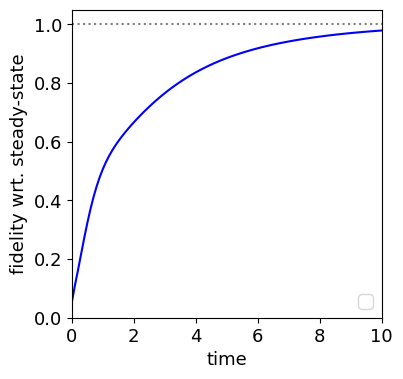

In [14]:
N = 40

self = qo.vdp(N=N, omega = 1+2*np.pi*0.05, gamma_1 = 2, gamma_2 = 0.1)

tlst = np.linspace(0, 10, 101)

rho_0 = qt.coherent(N, -1+1j)

Ham, c_ops = self.dynamics()
rho_ss = qt.steadystate(Ham, c_ops)

qo.fidelity_ss(self.dynamics(),rho_0, tlst, rho_ss, True)

Omega_1, Omega_2 = self.shortcut_impens(rho_0, tau = 0.5, timepoints =101, dy = 0, maxiter = 100, save_to_osc = False, plot_trajectory = False)

tlst_2 = np.concatenate((np.linspace(0, 0.5, 101), np.linspace(2, 10, 101)[1:]))
self.Omega_1 = np.concatenate((Omega_1, np.zeros(shape = (100,))))
self.Omega_2 = np.concatenate((Omega_2, np.full(shape = (100,),fill_value = 1)))

qo.fidelity_ss(self.dynamics(), rho_0, tlst_2, rho_ss, True)


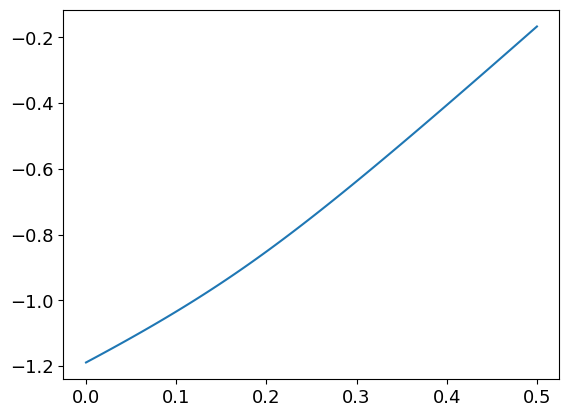

In [11]:
t = np.linspace(0, 0.5, 101)
plt.plot(t, self.Omega_2[:101])
plt.show()